# Data Analysis, AI and Optimization Project: To bee or not to bee 

## Group members: 
- Imad Rachati
- Elimanel Ramel
- Clément Sanh
- Quentin Vermont

## Library loading

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
import csv
import cv2
import skimage
import warnings
warnings.filterwarnings('ignore')

# Part 1 : Feature Extraction [7 points]

In this part, we'll start extracting the different features that we'll use for our Machine Learning and Deep Learning Algorithms.

Open the classif.xlsx file to get the table data associating each image with the bug type and its associated species.

In [11]:
bug_data = pd.read_excel("Data/classif.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: 'Data/classif.xlsx'

We can extract each image and each mask from their respective folders and store them in individual arrays.

In [2]:
im_dir_path = r"./Data/picture/"
mask_dir_path = r"./Data/masks/"

pictures_path = [im_dir_path + "{0}.JPG".format(i) for i in range(1,bug_data.shape[0] + 1)]
masks_path = [mask_dir_path + "binary_{0}.tif".format(i) for i in range(1,bug_data.shape[0] + 1)]

NameError: name 'bug_data' is not defined

## Symmetry Index

In [8]:
def calculate_symmetry_index_within_insect_region(bug_image):
    # Calculate the bounding box of the bug
    non_zero_indices = np.nonzero(bug_image)
    min_x = np.min(non_zero_indices[1])
    max_x = np.max(non_zero_indices[1])
    min_y = np.min(non_zero_indices[0])
    max_y = np.max(non_zero_indices[0])
    bug_width = max_x - min_x + 1
    bug_height = max_y - min_y + 1
    
    # Calculate the center of the bounding box
    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2
    
    # Choose the longest axis as a starting point
    axis_length = max(bug_width, bug_height)
    
    
    # Initialize symmetry_index
    symmetry_index = 0
    
    # Iterate through different axes
    for angle in range(0, 180, 5):  
        
        # Calculate the new axis coordinates
        end_x = center_x + int(np.cos(np.deg2rad(angle)) * axis_length)
        end_y = center_y + int(np.sin(np.deg2rad(angle)) * axis_length)

        start_x = center_x - int(np.cos(np.deg2rad(angle)) * axis_length)
        start_y = center_y - int(np.sin(np.deg2rad(angle)) * axis_length)
        
        
        # Line equation parameters
        a = end_y - start_y
        b = start_x - end_x
        c = end_x * start_y - start_x * end_y

        
        # Split the bug into two parts along the axis
        part_a = []
        part_b = []
        for y in range(min_y, max_y + 1):
            for x in range(min_x, max_x + 1):
                if a * x + b * y + c < 0:
                    part_a.append(bug_image[y, x])
                elif a * x + b * y + c > 0:
                    part_b.append(bug_image[y, x])
        
        # Calculate the intersection and union of A' and B'
        intersection = np.sum(part_a) + np.sum(part_b)
        union = len(part_a) + len(part_b)

        # Calculate the symmetry index for this axis
        symmetry_index_axis = 0.5 * (intersection / union)
        
        # Update symmetry index if it's greater than the current one
        symmetry_index = max(symmetry_index, symmetry_index_axis)
    
    return symmetry_index

### Complexité totale

La boucle sur les angles s'exécute 36 fois et à chaque itération, il y a une double boucle sur les pixels dans la boîte englobante, ce qui donne une complexité totale de \( 36 \cdot O(n \cdot m) \).

Ainsi, la complexité totale du code est \( O(n \cdot m) \).

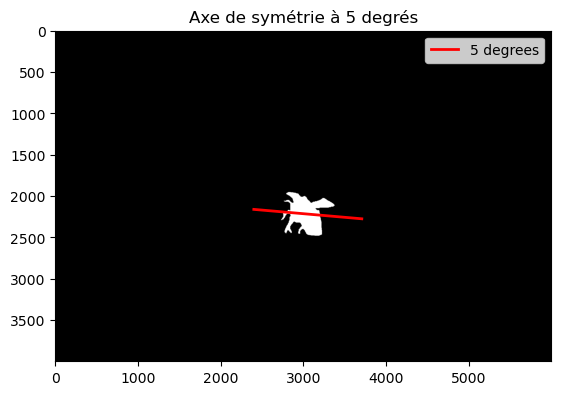

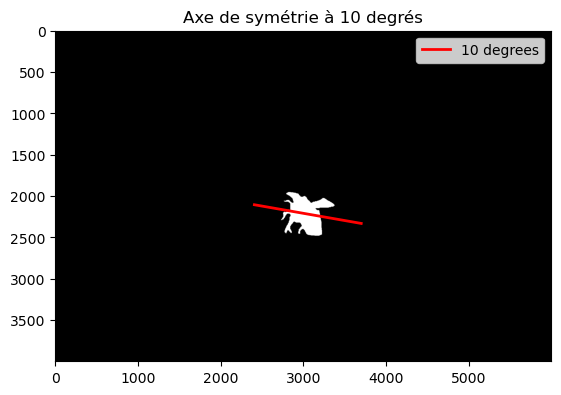

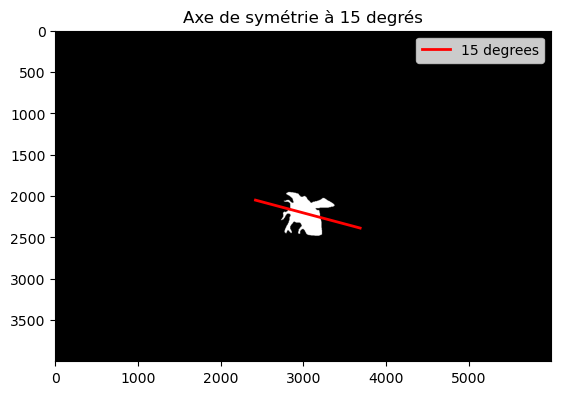

In [ ]:
def plot_axis_over_insect(bug_image, angle):
    # Calculate the bounding box of the bug
    non_zero_indices = np.nonzero(bug_image)
    min_x = np.min(non_zero_indices[1])
    max_x = np.max(non_zero_indices[1])
    min_y = np.min(non_zero_indices[0])
    max_y = np.max(non_zero_indices[0])
    bug_width = max_x - min_x + 1
    bug_height = max_y - min_y + 1
    
    # Calculate the center of the bounding box
    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2
    
    # Choose the longest axis as a starting point
    axis_length = max(bug_width, bug_height)
    
    # Calculate the new axis coordinates
    end_x = center_x + int(np.cos(np.deg2rad(angle)) * axis_length)
    end_y = center_y + int(np.sin(np.deg2rad(angle)) * axis_length)
    start_x = center_x - int(np.cos(np.deg2rad(angle)) * axis_length)
    start_y = center_y - int(np.sin(np.deg2rad(angle)) * axis_length)
    
    # Plot the bug image and the axis
    plt.imshow(bug_image, cmap='gray')
    plt.plot([start_x, end_x], [start_y, end_y], 'r-', linewidth=2, label=f'{angle} degrees')
    plt.legend()
    plt.title(f'Axe de symétrie à {angle} degrés')
    plt.show()

# Example usage
# Create a binary image of an insect (for demonstration purposes, replace with actual image)
bug_image = np.array(cv2.imread(masks_path[0], cv2.IMREAD_GRAYSCALE))

# Plot axes at 5, 10, and 15 degrees
for i in [5,10,15]:
    plot_axis_over_insect(bug_image, i)

In [ ]:
index_sym =  []
for i in masks_path:
    index_sym.append(calculate_symmetry_index_within_insect_region(np.array(cv2.imread(i, cv2.IMREAD_GRAYSCALE))))

In [ ]:
bug_data["Symetry Index"] = index_sym

Highest Symmetry Index (Bug ID: 86, Symmetry Index: 96.32)
Lowest Symmetry Index (Bug ID: 81, Symmetry Index: 25.07)


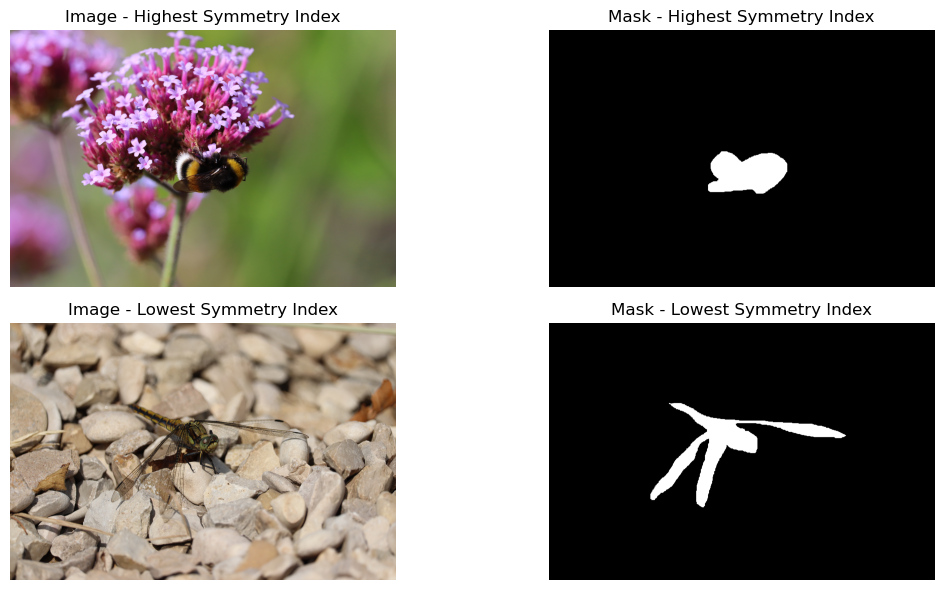

In [ ]:
# Find index of insect with highest symmetry index
max_symmetry_index = bug_data['Symetry Index'].idxmax()
max_symmetry_value = bug_data['Symetry Index'].max()

# Find index of insect with lowest symmetry index
min_symmetry_index = bug_data['Symetry Index'].idxmin()
min_symmetry_value = bug_data['Symetry Index'].min()

print("Highest Symmetry Index (Bug ID: {}, Symmetry Index: {:.2f})".format(max_symmetry_index, max_symmetry_value))
print("Lowest Symmetry Index (Bug ID: {}, Symmetry Index: {:.2f})".format(min_symmetry_index, min_symmetry_value))

max_symmetry_img = np.array(Image.open(im_dir_path + "{0}.JPG".format(max_symmetry_index + 1)))
max_symmetry_mask = np.array(Image.open(mask_dir_path + "binary_{0}.tif".format(max_symmetry_index + 1)))
min_symmetry_img = np.array(Image.open(im_dir_path + "{0}.JPG".format(min_symmetry_index + 1)))
min_symmetry_mask = np.array(Image.open(mask_dir_path + "binary_{0}.tif".format(min_symmetry_index + 1)))

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(max_symmetry_img)
plt.title('Image - Highest Symmetry Index')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(max_symmetry_mask, cmap='gray')
plt.title('Mask - Highest Symmetry Index')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(min_symmetry_img)
plt.title('Image - Lowest Symmetry Index')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(min_symmetry_mask, cmap='gray')
plt.title('Mask - Lowest Symmetry Index')
plt.axis('off')

plt.tight_layout()
plt.show()

## The ratio between the 2 longest orthogonal lines that can cross the bug (smallest divided by longuest)
The second feature we're being told to implement is the ratio between the 2 longest orthogonal lines that can cross the bug (smallest divided by 
longuest).

In [19]:
def find_longest_line(mask):
    # Apply Hough Line Transform
    lines = cv2.HoughLinesP(mask, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    max_line_length = 0
    longest_line = None

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Calculate length of the line
            line_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            # Update longest line if the current line is longer
            if line_length > max_line_length:
                max_line_length = line_length
                longest_line = line[0]
    
    return longest_line

def find_longest_perpendicular_line(mask, longest_line):

    x1, y1, x2, y2 = longest_line

    # Handle the case where the longest line is vertical (iterate over all horizontal lines)
    if x1 == x2:
        y = (y1 + y2) // 2  # Use the midpoint between the endpoints
        line_length = 0
        x_start, x_end = 0, mask.shape[1] - 1
        for x in range(mask.shape[1]):
            if mask[y, x] > 0:
                if line_length == 0:
                    x_start = x
                line_length += 1
            else:
                if line_length > 0:
                    x_end = x - 1
                    line_length = 0

        # Return the longest horizontal line segment
        longest_perpendicular_line = (x_start, y, x_end, y)
        return longest_perpendicular_line

    # Handle the case where the longest line is horizontal
    if y1 == y2:
        max_line_length = 0
        longest_vertical_line = None

        # Iterate over each x-coordinate along the horizontal line
        for x in range(x1, x2 + 1):
            line_length = 0
            y_start, y_end = 0, mask.shape[0] - 1
            for y in range(mask.shape[0]):
                if mask[y, x] > 0:
                    if line_length == 0:
                        y_start = y
                    line_length += 1
                else:
                    if line_length > 0:
                        y_end = y - 1
                        line_length = 0

            # Update longest vertical line if the current line segment is longer
            if y_end - y_start > max_line_length:
                max_line_length = y_end - y_start
                longest_vertical_line = (x, y_start, x, y_end)

        return longest_vertical_line

    # For non-vertical and non-horizontal lines, continue with the existing logic
    else:
        # Compute the slope of the longest line
        slope = (y2 - y1) / (x2 - x1)
        perpendicular_slope = -1 / slope

        max_line_length = 0
        longest_perpendicular_line = None

        # Iterate over pixels in the mask along the perpendicular line
        for x in range(mask.shape[1]):

            y = int(slope * (x - x1) + y1)

            # Check if the y-coordinate is within the bounds of the image
            if 0 <= y < mask.shape[0]:
                # Check if the pixel in the mask is part of the insect
                if mask[y, x] > 0:

                    line_length = 1

                    # Extend the line segment in both directions
                    while True:
                        # Calculate coordinates of the next point along the line in one direction
                        x_next = x + line_length
                        y_next = int(perpendicular_slope * (x_next - x) + y)
                        # Check if the next point is within the bounds of the image
                        if 0 <= y_next < mask.shape[0] and 0 <= x_next < mask.shape[1]:
                            # Check if the pixel in the mask is part of the object
                            if mask[y_next, x_next] > 0:
                                # Increment line segment length
                                line_length += 1
                            else:
                                break
                        else:
                            break

                    # Extend the line segment in the other direction until interruption
                    line_length_temp = 1
                    while True:
                        # Calculate coordinates of the next point along the line in the opposite direction
                        x_temp = x - line_length_temp
                        y_temp = int(perpendicular_slope * (x_temp - x) + y)
                        # Check if the next point is within the bounds of the image
                        if 0 <= y_temp < mask.shape[0] and 0 <= x_temp < mask.shape[1]:
                            # Check if the pixel in the mask is part of the object
                            if mask[y_temp, x_temp] > 0:
                                # Increment line segment length
                                line_length_temp += 1
                            else:
                                break
                        else:
                            break

                    # Update longest perpendicular line if the current line segment is longer
                    if line_length + line_length_temp > max_line_length:
                        max_line_length = line_length + line_length_temp
                        # Store endpoints of the line segment
                        x_start = x_temp + 1
                        y_start = y_temp
                        x_end = x_next - 1
                        y_end = y_next

                        longest_perpendicular_line = (x_start, y_start, x_end, y_end)

        return longest_perpendicular_line
    
# Function to calculate the ratio between the lengths of two lines
def calculate_ratio(line1, line2):
    if line1 is not None and line2 is not None:
        length_line1 = np.sqrt((line1[2] - line1[0])**2 + (line1[3] - line1[1])**2)
        length_line2 = np.sqrt((line2[2] - line2[0])**2 + (line2[3] - line2[1])**2)
        
        # En gros là c'est de la magouille parce que jsp pk des fois le truc trouve pas la longest et donc ça donne un ratio > 1
        if length_line1 > length_line2:
            ratio = length_line2 / length_line1
            return ratio, line1, line2
        else:
            ratio = length_line1 / length_line2
            return ratio, line2, line1
    else:
        return None, None, None



In [ ]:
filename = "ratio_longest_2.csv"

with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(["Image Index", "Ratio"])

    for i,path in enumerate(masks_path):

        longest_line = find_longest_line(np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE)))
        longest_perpendicular_line = find_longest_perpendicular_line(np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE)), longest_line)

        ratio, _, _ = calculate_ratio(longest_perpendicular_line, longest_line)
        
        writer.writerow([i + 1, ratio])

## Bug proportion in picture feature

In [ ]:
test = np.array(cv2.imread(masks_path[1], cv2.IMREAD_GRAYSCALE))

In [32]:
def calculate_bug_to_image_pixels_ratio(mask):
    # We retrieve the total number of pixels of the full image
    total_pixels = mask.size
    
    # We get the nb of non zero pixesl (the size of the bug)
    bug_pixels = cv2.countNonZero(mask)
    
    # We simply compute the ratio
    ratio = bug_pixels / total_pixels
    
    return ratio

In [ ]:
ratios = []
for m in masks_path:
    ratio = calculate_bug_to_image_pixels_ratio(np.array(cv2.imread(m, cv2.IMREAD_GRAYSCALE)))
    ratios.append(ratio)

# Add ratio indices to bug_data dataframe
bug_data['ratio_pixel'] = ratios

bug_data.head()

,ID,bug type,species,Symetry Index,ratio_pixel
0,1,Bee,Apis mellifera,62.647124,0.007428
1,2,Bee,Apis mellifera,53.516880,0.008553
2,3,Bee,Apis mellifera,56.318707,0.022093
3,4,Bee,Apis mellifera,53.217788,0.013187
4,5,Bee,Apis mellifera,49.407421,0.009165


In [ ]:
bug_data.to_excel("ratio pixel index.xlsx")

Image with highest ratio pixel (Bug ID: 82, Ratio: 0.1875)
Image with lowest ratio pixel (Bug ID: 26, Ratio: 0.0038)


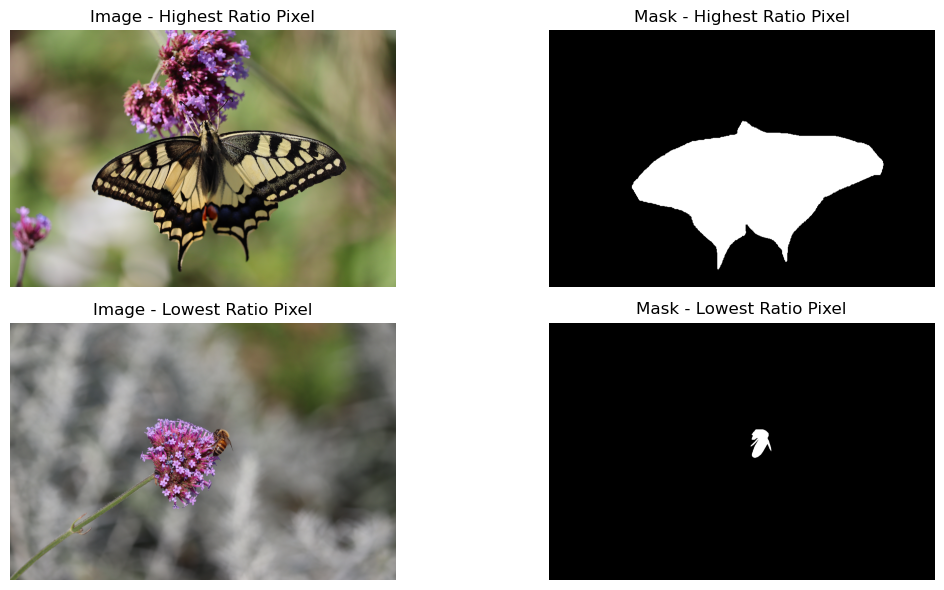

In [ ]:
# Find index of mask with highest ratio

max_ratio_index = bug_data['ratio_pixel'].idxmax()
max_ratio_value = bug_data['ratio_pixel'].max()

# Find index of mask with lowest ratio
min_ratio_index = bug_data['ratio_pixel'].idxmin()
min_ratio_value = bug_data['ratio_pixel'].min()

# Load images and masks with highest and lowest ratio
max_ratio_img = np.array(Image.open(im_dir_path + "{0}.JPG".format(max_ratio_index + 1)))
max_ratio_mask = np.array(Image.open(mask_dir_path + "binary_{0}.tif".format(max_ratio_index + 1)))
min_ratio_img = np.array(Image.open(im_dir_path + "{0}.JPG".format(min_ratio_index + 1)))
min_ratio_mask = np.array(Image.open(mask_dir_path + "binary_{0}.tif".format(min_ratio_index + 1)))

print("Image with highest ratio pixel (Bug ID: {}, Ratio: {:.4f})".format(max_ratio_index, max_ratio_value))
print("Image with lowest ratio pixel (Bug ID: {}, Ratio: {:.4f})".format(min_ratio_index, min_ratio_value))

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(max_ratio_img)
plt.title('Image - Highest Ratio Pixel')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(max_ratio_mask, cmap='gray')
plt.title('Mask - Highest Ratio Pixel')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(min_ratio_img)
plt.title('Image - Lowest Ratio Pixel')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(min_ratio_mask, cmap='gray')
plt.title('Mask - Lowest Ratio Pixel')
plt.axis('off')

plt.tight_layout()
plt.show()

## Picture color caracteristics calcul in red, blue, green

In [42]:
# Fonction pour calculer les caractéristiques à l'intérieur du masque pour chaque canal de couleur
def calculate_color_features_within_mask(img, mask):
    """
    Calcule les caractéristiques à l'intérieur du masque pour chaque canal de couleur.

    Args:
        img (numpy.ndarray): Image RGB.
        mask (numpy.ndarray): Masque binaire.

    Returns:
        list: Liste des caractéristiques pour chaque canal de couleur.
    """
    color_features = []

    # Normaliser les canaux de couleur
    img = img.astype(np.float32) / 255.0

    # Séparer les canaux de couleur de l'image
    b, g, r = cv2.split(img)

    # Calculer les caractéristiques pour chaque canal de couleur
    for channel in [r, g, b]:
        # Appliquer le masque à chaque canal de couleur pour ne garder que les pixels de l'insecte
        masked_channel = channel * (mask / 255)

        # Extraire uniquement les pixels à l'intérieur du masque
        insect_pixels = masked_channel[mask > 0]

        # Calculer les caractéristiques statistiques pour le canal actuel
        if len(insect_pixels) > 0:
            min_val = np.min(insect_pixels)
            max_val = np.max(insect_pixels)
            mean_val = np.mean(insect_pixels)
            std_dev = np.std(insect_pixels)
            quartiles = np.percentile(insect_pixels, [25, 50, 75])
        else:
            # Si aucun pixel d'insecte n'est présent, retourner des valeurs par défaut
            min_val, max_val, mean_val, std_dev, quartiles = 0, 0, 0, 0, [0, 0, 0]

        # Stocker les caractéristiques dans la liste
        color_features.append({
            'min_intensity': min_val,
            'max_intensity': max_val,
            'mean_intensity': mean_val,
            'std_deviation_intensity': std_dev,
            'quartiles_intensity': quartiles
        })

    return color_features


In [ ]:
# Liste pour stocker les caractéristiques calculées pour chaque insecte
caracteristiques = []

# Parcourir les images et masques dans les tableaux picture_arr et mask_arr
for i in range(len(masks_path)):
    # Charger l'image de base et le masque correspondant
    img = np.array(Image.open(pictures_path[i]))
    mask = np.array(cv2.imread(masks_path[i], cv2.IMREAD_GRAYSCALE))


    # Calculer les caractéristiques à l'intérieur du masque pour chaque canal de couleur
    color_features = calculate_color_features_within_mask(img, mask)

    # Stocker les caractéristiques dans la liste principale
    caracteristiques.append({
        'image': i + 1,  # Utiliser i + 1 car l'index commence à 0 mais les images sont numérotées à partir de 1
        'canal rouge': color_features[0],
        'canal vert': color_features[1],
        'canal bleu': color_features[2],
    })

# Afficher les caractéristiques de la première image
print("Caractéristiques de la première image :")
print(caracteristiques[0])


In [ ]:

# Liste pour stocker les caractéristiques calculées pour chaque insecte
caracteristiques = []

# Parcourir les images et masques dans les tableaux picture_arr et mask_arr
for i in range(len(masks_path)):
    # Charger l'image de base et le masque correspondant
    img = np.array(Image.open(pictures_path[i]))
    mask = np.array(cv2.imread(masks_path[i], cv2.IMREAD_GRAYSCALE))

    # Calculer les caractéristiques à l'intérieur du masque pour chaque canal de couleur
    color_features = calculate_color_features_within_mask(img, mask)

    # Stocker les caractéristiques dans la liste principale
    caracteristiques.append({
        'image': i + 1,  # Utiliser i + 1 car l'index commence à 0 mais les images sont numérotées à partir de 1
        'canal red': color_features[0],
        'canal green': color_features[1],
        'canal blue': color_features[2],
    })

# Création du DataFrame à partir de la liste caracteristiques
data = []
for insecte in caracteristiques:
    row_data = {'ID': insecte['image']}
    for couleur in ['red', 'green', 'blue']:
        canal = insecte['canal ' + couleur]
        row_data['min_' + couleur] = canal['min_intensity']
        row_data['max_' + couleur] = canal['max_intensity']
        row_data['mean_' + couleur] = canal['mean_intensity']
        row_data['std_' + couleur] = canal['std_deviation_intensity']
        row_data['q1_' + couleur] = canal['quartiles_intensity'][0]
        row_data['median_' + couleur] = canal['quartiles_intensity'][1]
        row_data['q3_' + couleur] = canal['quartiles_intensity'][2]
    data.append(row_data)

df = pd.DataFrame(data)


In [ ]:
#bug_data = bug_data.append(df)
bug_data = bug_data.merge(df,how="inner",on="ID")
bug_data

,ID,bug type,species,Symetry Index,ratio_pixel,min_red,max_red,mean_red,std_red,q1_red,...,q1_green,median_green,q3_green,min_blue,max_blue,mean_blue,std_blue,q1_blue,median_blue,q3_blue
0,1,Bee,Apis mellifera,62.647124,0.007428,0.000000,0.725490,0.147434,0.138390,0.050980,...,0.066667,0.133333,0.309804,0.000169,0.796078,0.253709,0.187710,0.094118,0.203922,0.380392
1,2,Bee,Apis mellifera,53.516880,0.008553,0.000000,0.956863,0.129841,0.130855,0.035294,...,0.062745,0.121569,0.309804,0.000507,0.972549,0.236177,0.164303,0.090196,0.203922,0.364706
2,3,Bee,Apis mellifera,56.318707,0.022093,0.000000,1.000000,0.242887,0.214925,0.050980,...,0.105882,0.321569,0.529412,0.000185,1.000000,0.411933,0.234196,0.207843,0.437493,0.592157
3,4,Bee,Apis mellifera,53.217788,0.013187,0.000000,0.739254,0.187801,0.144383,0.066667,...,0.101961,0.223529,0.454902,0.000261,0.823529,0.330453,0.185349,0.160784,0.325490,0.521569
4,5,Bee,Apis mellifera,49.407421,0.009165,0.000000,0.960784,0.304900,0.237488,0.086275,...,0.141176,0.333333,0.631373,0.000354,1.000000,0.467391,0.250971,0.227451,0.509804,0.698039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,Bee,Apis mellifera,59.697674,0.006250,0.000000,0.800000,0.218259,0.150850,0.094118,...,0.145098,0.274510,0.407843,0.027451,0.839216,0.387069,0.183529,0.227451,0.384314,0.552941
246,247,Bee,Apis mellifera,57.320556,0.020050,0.000000,1.000000,0.222405,0.154019,0.098039,...,0.098039,0.203922,0.396078,0.027451,1.000000,0.350115,0.205485,0.172549,0.321569,0.513726
247,248,Bee,Apis mellifera,48.870187,0.007032,0.000000,0.913725,0.224266,0.203385,0.058824,...,0.070588,0.141176,0.403922,0.019608,0.988235,0.313307,0.213187,0.133333,0.235294,0.486275
248,249,Bee,Apis mellifera,54.868455,0.011959,0.011765,1.000000,0.404613,0.209736,0.243137,...,0.282353,0.466667,0.580392,0.023529,1.000000,0.550792,0.226796,0.407843,0.552941,0.717647


# Part 2 : Data Vizualisation

In [3]:
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE

In [4]:
bug_data_with_feature = pd.read_csv("Data/classif_with_feature_extraction.csv", sep=";")


In [5]:
arr_bug_data_with_feature = np.array(bug_data_with_feature.drop(columns=['bug type','ID','species'], axis=1))
classe = bug_data_with_feature['bug type']
arr_bug_data_with_feature

array([[0.81438846, 0.00742804, 0.        , ..., 0.89677859, 0.99231925,
        0.9939036 ],
       [0.74106176, 0.008553  , 0.        , ..., 0.89828282, 0.99119784,
        0.9935351 ],
       [0.82586527, 0.02209313, 0.        , ..., 0.95316953, 0.97748571,
        0.98216094],
       ...,
       [0.65162498, 0.0070325 , 0.        , ..., 0.9462685 , 0.99275423,
        0.99424527],
       [0.7250664 , 0.01195925, 0.01176471, ..., 0.96809688, 0.98780764,
        0.98932747],
       [0.87904473, 0.02336667, 0.        , ..., 0.95569974, 0.97626625,
        0.97838788]])

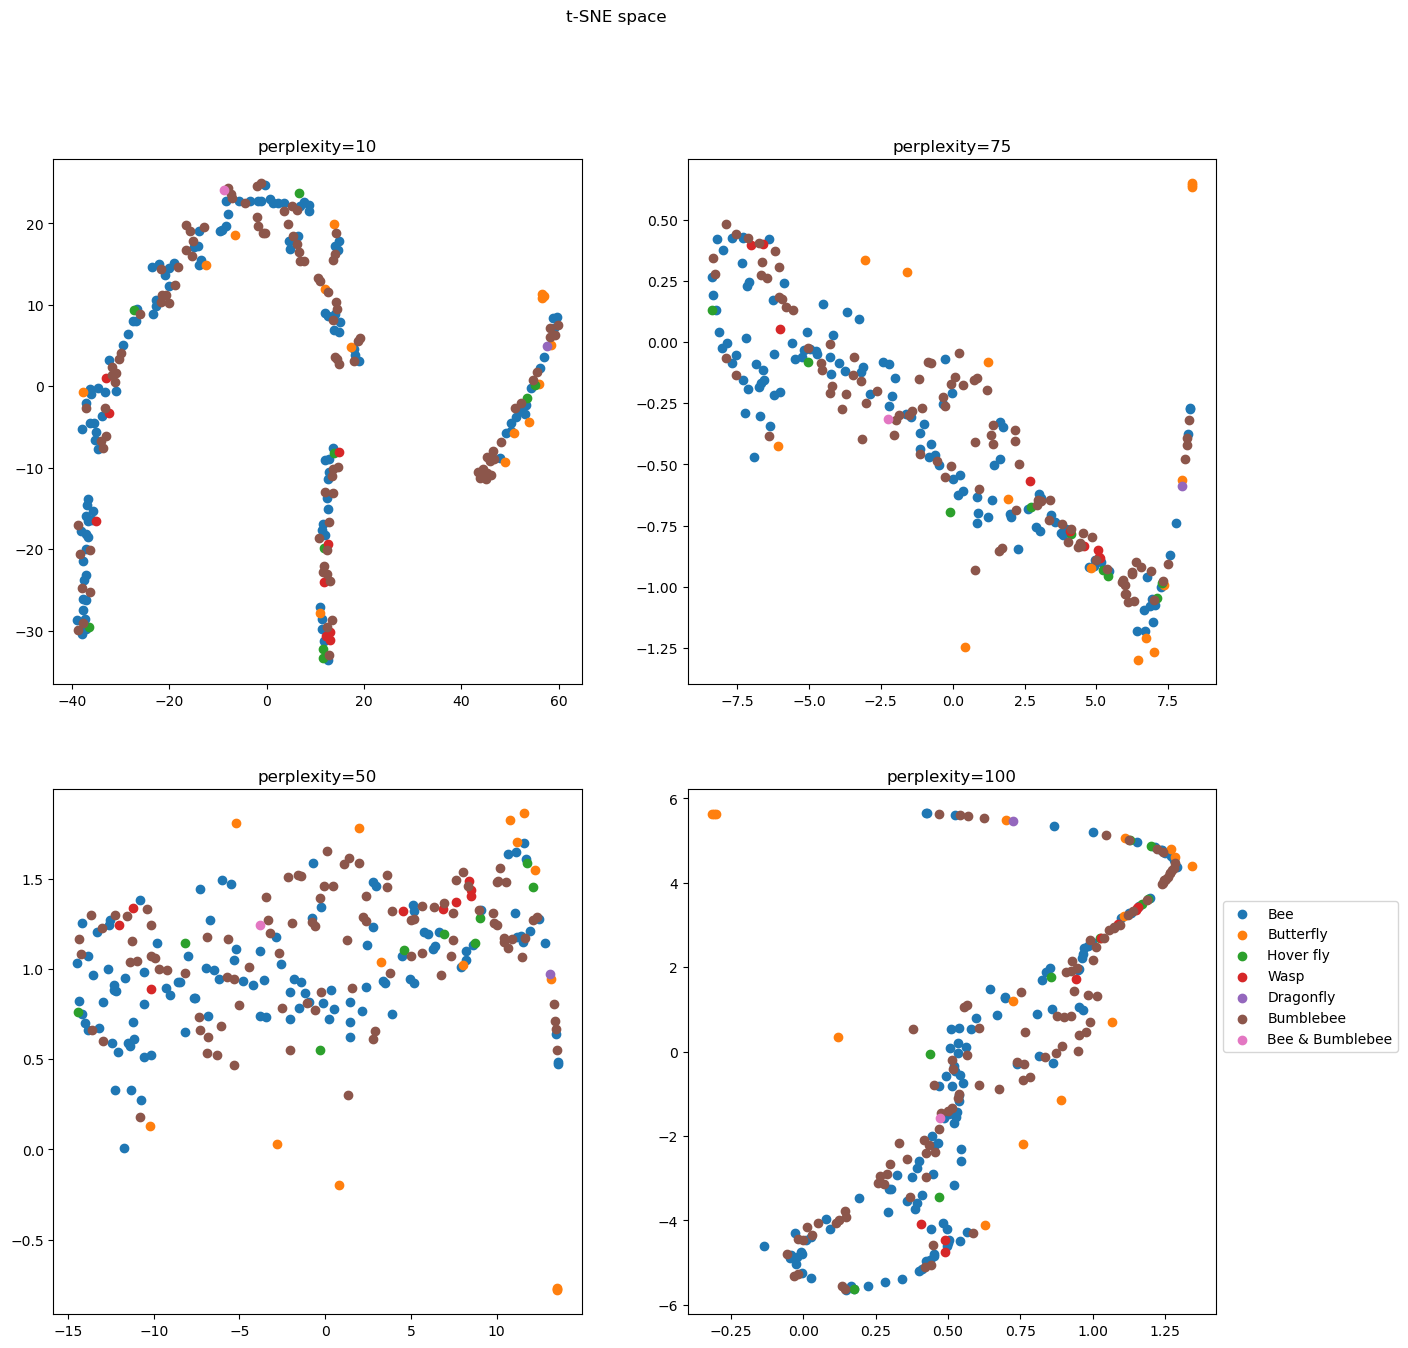

In [7]:
nb_lines = 2
nb_cols = 2

fig, ax = plt.subplots(nb_lines, nb_cols, figsize=(15, 15))
line_ids, col_ids = np.meshgrid(range(0, nb_lines), 
                                range(0, nb_cols))
fig.suptitle('t-SNE space', fontsize=12)
for perp, line_id, col_id in zip([10,50,75,100],
                                      line_ids.flatten(), col_ids.flatten()):
   model = TSNE(n_components=2,perplexity=perp, random_state=0)
   digits_tsne = model.fit_transform(arr_bug_data_with_feature)
   for dig in bug_data_with_feature['bug type'].unique():
         ax[line_id, col_id].scatter(digits_tsne[bug_data_with_feature['bug type']==dig, 0], digits_tsne[bug_data_with_feature['bug type']==dig, 1],label=dig);    
   
   ax[line_id, col_id].set_title("perplexity={0}".format(perp))
plt.legend(bbox_to_anchor=(1, 0.8));  

# Part 3 : Machine Learning and Deep Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV, validation_curve, StratifiedKFold
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.feature_selection import *
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Charger les données
bug_data_with_feature = pd.read_csv("Data/classif_with_feature_extraction.csv", sep=";")
bug_data_with_feature = bug_data_with_feature.drop(index=153)



# Division des données en ensemble d'entraînement et ensemble de test
X = bug_data_with_feature.drop(columns=['bug type','ID','species'], axis=1)
y = bug_data_with_feature['bug type']
y_2 = [bug if bug == "Bee" or bug == "Bumblebee" else "Autre" for bug in bug_data_with_feature['bug type']]

## Feature selection

Eliminate feature which have a high correlation coeficient to dodge redundance 

In [4]:
# Step 1: Correlation Analysis
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_reduced = X.drop(columns=to_drop)
X_reduced.shape

(249, 20)

Eliminate features which have a small variance 

In [5]:
median_var = np.median(X_reduced.var(axis=0))
selector = VarianceThreshold(threshold=round(median_var,ndigits=3))
selector.fit_transform(X_reduced)

array([[ 0.81438846,  0.14743419,  0.05098039, ...,  0.62647124,
         6.89312285,  0.10850234],
       [ 0.74106176,  0.12984112,  0.03529412, ...,  0.5351688 ,
         6.84665513,  0.10392585],
       [ 0.82586527,  0.24288683,  0.05098039, ...,  0.56318707,
        20.73157173,  0.31792627],
       ...,
       [ 0.65162498,  0.22426626,  0.05882353, ...,  0.48870187,
         4.86780525,  0.08890826],
       [ 0.7250664 ,  0.40461299,  0.24313725, ...,  0.54868455,
        11.67051034,  0.18870876],
       [ 0.87904473,  0.30362863,  0.09803922, ...,  0.62425022,
        26.46762727,  0.49081343]])

In [6]:
feature_selected = list(np.array(X_reduced.columns)[selector.get_support()])

In [7]:
feature_selected

['Axe ratio',
 'mean_red',
 'q1_red',
 'max_green',
 'mean_green',
 'q1_green',
 'mean_blue',
 'Symmetry coef',
 'GLCM_contrast',
 'GLCM_dissimilarity']

## Supervised Machine Learning : Multinomial logistic regression

In [14]:
# Division des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X[feature_selected], y,test_size=0.2, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X[feature_selected], y_2,test_size=0.2, random_state=0)

In [57]:
# Définition des hyperparamètres à rechercher
param_grid = {
    'penalty': ['l2','l1'],  # 'l1' peut aussi être utilisé si solver='liblinear'
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

# Initialisation du modèle de régression logistique multinomiale
log_reg = LogisticRegression(multi_class='multinomial')

# Recherche des meilleurs paramètres avec GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_2, y_train_2)

# Affichage des meilleurs paramètres et de la meilleure performance
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure performance:", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres: {'penalty': 'l2', 'solver': 'newton-cg'}
Meilleure performance: 0.6282051282051282


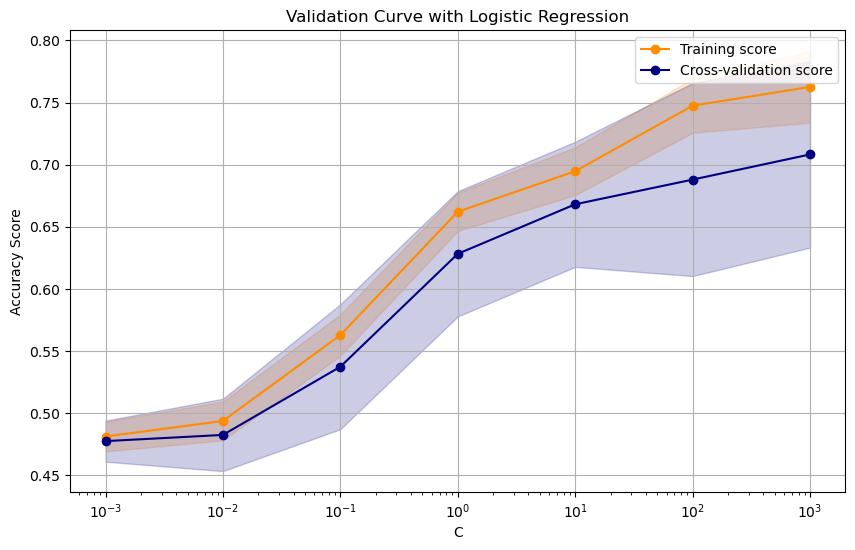

In [58]:
# Définir une plage de valeurs pour le paramètre C
param_range = np.logspace(-3, 3, 7)

# Initialisation du modèle de régression logistique multinomiale
best_log_reg = grid_search.best_estimator_

# Utilisation de validation_curve pour le paramètre C
train_scores, test_scores = validation_curve(
    estimator=best_log_reg,
    X=X_train_2,
    y=y_train_2,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calculez les moyennes et les écarts-types des scores pour les ensembles d'entraînement et de test
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracez la courbe de validation
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [59]:
best_log_reg

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [60]:
best_log_reg.set_params(C=1000)
y_pred_test = best_log_reg.predict(X_test)
y_pred_train = best_log_reg.predict(X_train)

# Évaluation du modèle sur les donnée de test
print("Classification Report for on test:")
print(classification_report(y_test_2, y_pred_test))

# Évaluation du modèle sur les donnée train
print("Classification Report for on train:")
print(classification_report(y_train_2, y_pred_train))

Classification Report for on test:
              precision    recall  f1-score   support

       Autre       1.00      0.29      0.44         7
         Bee       0.67      0.80      0.73        20
   Bumblebee       0.79      0.83      0.81        23

    accuracy                           0.74        50
   macro avg       0.82      0.64      0.66        50
weighted avg       0.77      0.74      0.73        50

Classification Report for on train:
              precision    recall  f1-score   support

       Autre       0.73      0.30      0.42        27
         Bee       0.62      0.82      0.71        95
   Bumblebee       0.75      0.61      0.67        77

    accuracy                           0.67       199
   macro avg       0.70      0.58      0.60       199
weighted avg       0.69      0.67      0.66       199



In [61]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate the model and collect the scores
n_scores = cross_val_score(best_log_reg, X, y_2, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print("Score : {0}".format(n_scores))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
np.median(n_scores)

Score : [0.72       0.8        0.8        0.84       0.8        0.72
 0.8        0.8        0.72       0.79166667 0.84       0.64
 0.8        0.64       0.92       0.88       0.72       0.76
 0.72       0.70833333 0.76       0.72       0.64       0.92
 0.88       0.8        0.76       0.8        0.8        0.70833333]
Mean Accuracy: 0.774 (0.073)


0.7958333333333334

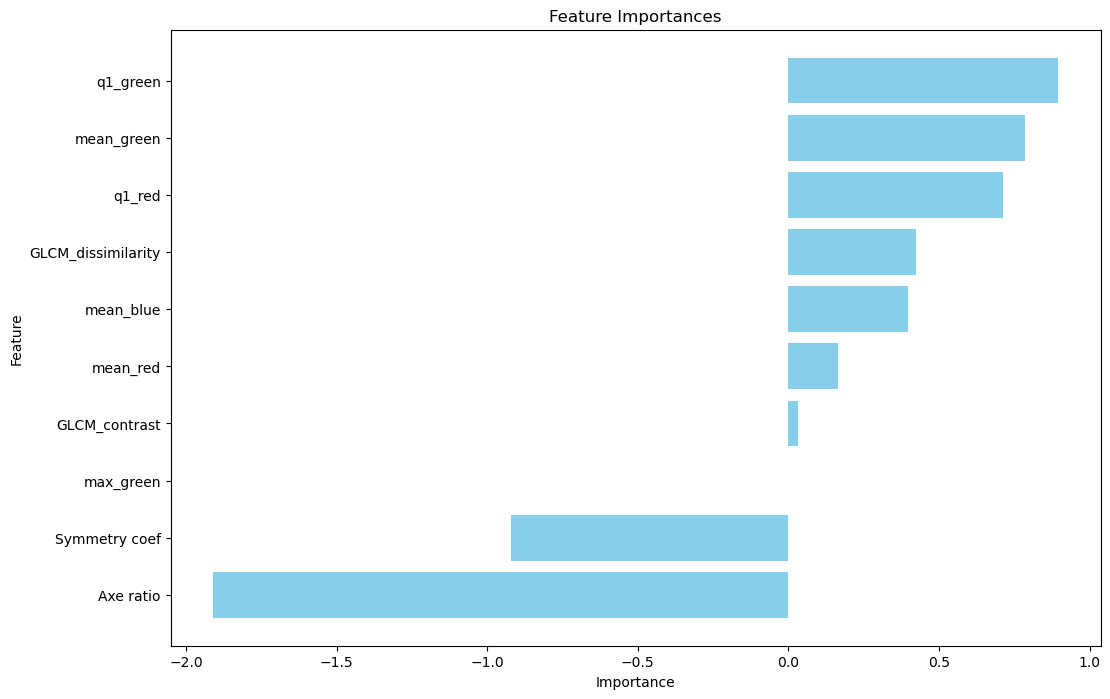

In [62]:
# Analyse de l'importance des caractéristiques
feature_importances = pd.DataFrame({'feature': X_train_2.columns, 'importance': best_log_reg.coef_[0]})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Tri des importances pour une meilleure visualisation
sorted_idx = feature_importances['importance'].sort_values(ascending=False).index
sorted_features = feature_importances.loc[sorted_idx]

# Création du graphique
plt.figure(figsize=(12, 8))
plt.barh(sorted_features['feature'], sorted_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Inverser l'axe pour afficher les plus importantes en haut
plt.show()

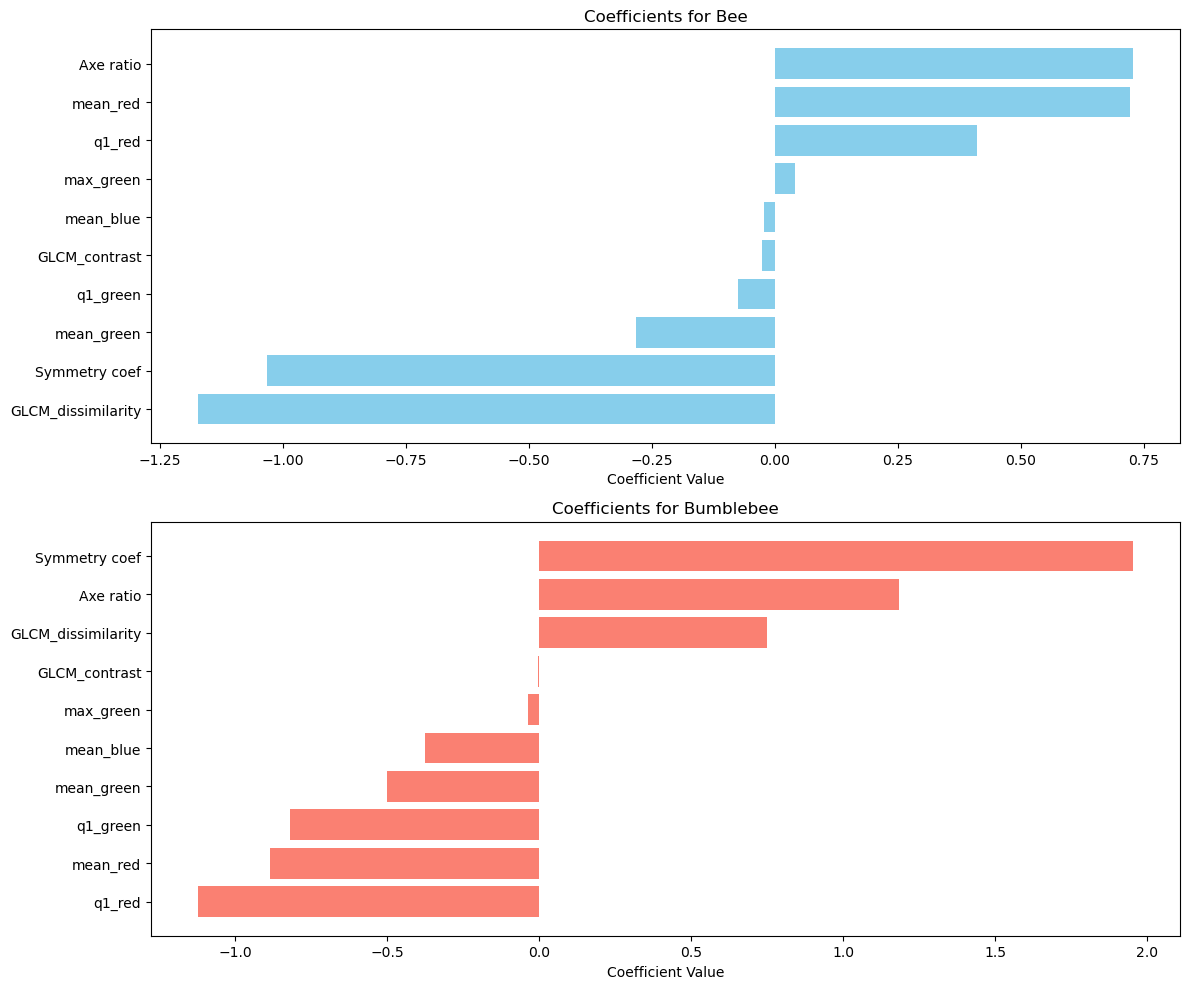

In [63]:

# Extraire les coefficients pour chaque classe
coefficients = pd.DataFrame(best_log_reg.coef_, columns=X_train_2.columns, index=best_log_reg.classes_)

bee_coefficients = coefficients.loc["Bee"].sort_values(ascending=False)
bumblebee_coefficients = coefficients.loc["Bumblebee"].sort_values(ascending=False)

# Visualisation des coefficients pour les classes Bee et Bumblebee
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].barh(bee_coefficients.index, bee_coefficients.values, color='skyblue')
ax[0].set_title('Coefficients for Bee')
ax[0].set_xlabel('Coefficient Value')
ax[0].invert_yaxis()  # Inverser l'axe pour afficher les plus importantes en haut

ax[1].barh(bumblebee_coefficients.index, bumblebee_coefficients.values, color='salmon')
ax[1].set_title('Coefficients for Bumblebee')
ax[1].set_xlabel('Coefficient Value')
ax[1].invert_yaxis()  # Inverser l'axe pour afficher les plus importantes en haut

plt.tight_layout()
plt.show()

## Supervised Machine Learning : SVM

In [64]:
# Définition des hyperparamètres à rechercher
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape':['ovo','ovr']
}

# Initialisation du modèle SVM
svm_model = SVC()

# Recherche des meilleurs paramètres avec GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_2, y_train_2)

# Affichage des meilleurs paramètres et de la meilleure performance
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure performance:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres: {'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'poly'}
Meilleure performance: 0.6826923076923077


In [65]:
grid_search.best_estimator_

SVC(decision_function_shape='ovo', gamma='auto', kernel='poly')

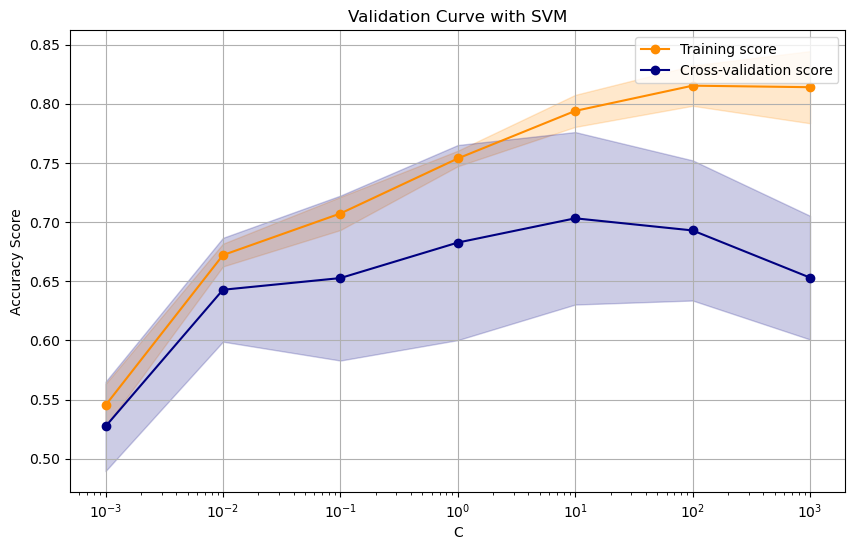

In [66]:
# Définir une plage de valeurs pour le paramètre C
param_range = np.logspace(-3, 3, 7)

# Initialisation du modèle SVM
best_svm = grid_search.best_estimator_


# Utilisation de validation_curve pour le paramètre C
train_scores, test_scores = validation_curve(
    estimator=best_svm,
    X=X_train_2,
    y=y_train_2,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calculez les moyennes et les écarts-types des scores pour les ensembles d'entraînement et de test
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracez la courbe de validation
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [67]:
best_svm.set_params(C=10)

# Prédiction sur l'ensemble de test avec les meilleurs paramètres
y_pred_test = best_svm.predict(X_test_2)
y_pred_train = best_svm.predict(X_train_2)

# Évaluation du modèle sur les donnée de test
print("Classification Report for on test:")
print(classification_report(y_test_2, y_pred_test))

# Évaluation du modèle sur les donnée train
print("Classification Report for on train:")
print(classification_report(y_train_2, y_pred_train))

Classification Report for on test:
              precision    recall  f1-score   support

       Autre       1.00      0.29      0.44         7
         Bee       0.64      0.90      0.75        20
   Bumblebee       0.85      0.74      0.79        23

    accuracy                           0.74        50
   macro avg       0.83      0.64      0.66        50
weighted avg       0.79      0.74      0.73        50

Classification Report for on train:
              precision    recall  f1-score   support

       Autre       0.93      0.52      0.67        27
         Bee       0.73      0.91      0.81        95
   Bumblebee       0.79      0.68      0.73        77

    accuracy                           0.76       199
   macro avg       0.82      0.70      0.73       199
weighted avg       0.78      0.76      0.76       199



In [68]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate the model and collect the scores
n_scores = cross_val_score(best_svm, X, y_2, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print("Score : {0}".format(n_scores))
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
np.median(n_scores)

Score : [0.76       0.72       0.68       0.8        0.72       0.76
 0.88       0.84       0.68       0.79166667 0.84       0.8
 0.72       0.68       0.8        0.92       0.76       0.76
 0.76       0.54166667 0.8        0.84       0.64       0.92
 0.68       0.64       0.68       0.88       0.8        0.75      ]
Mean Accuracy: 0.761 (0.086)


0.76

## Supervised Ensemble Learning : Random Forest

In [37]:
df = pd.read_csv('Data/classif_with_feature_extraction.csv', delimiter=';')

# Separate features and target
X = df.drop(['ID', 'bug type', 'species'], axis=1)
y = df['bug type']
y_2 = ['Bee' if bug == 'Bee' else 'Bumblebee' if bug == 'Bumblebee' else 'Autre' for bug in df['bug type']]

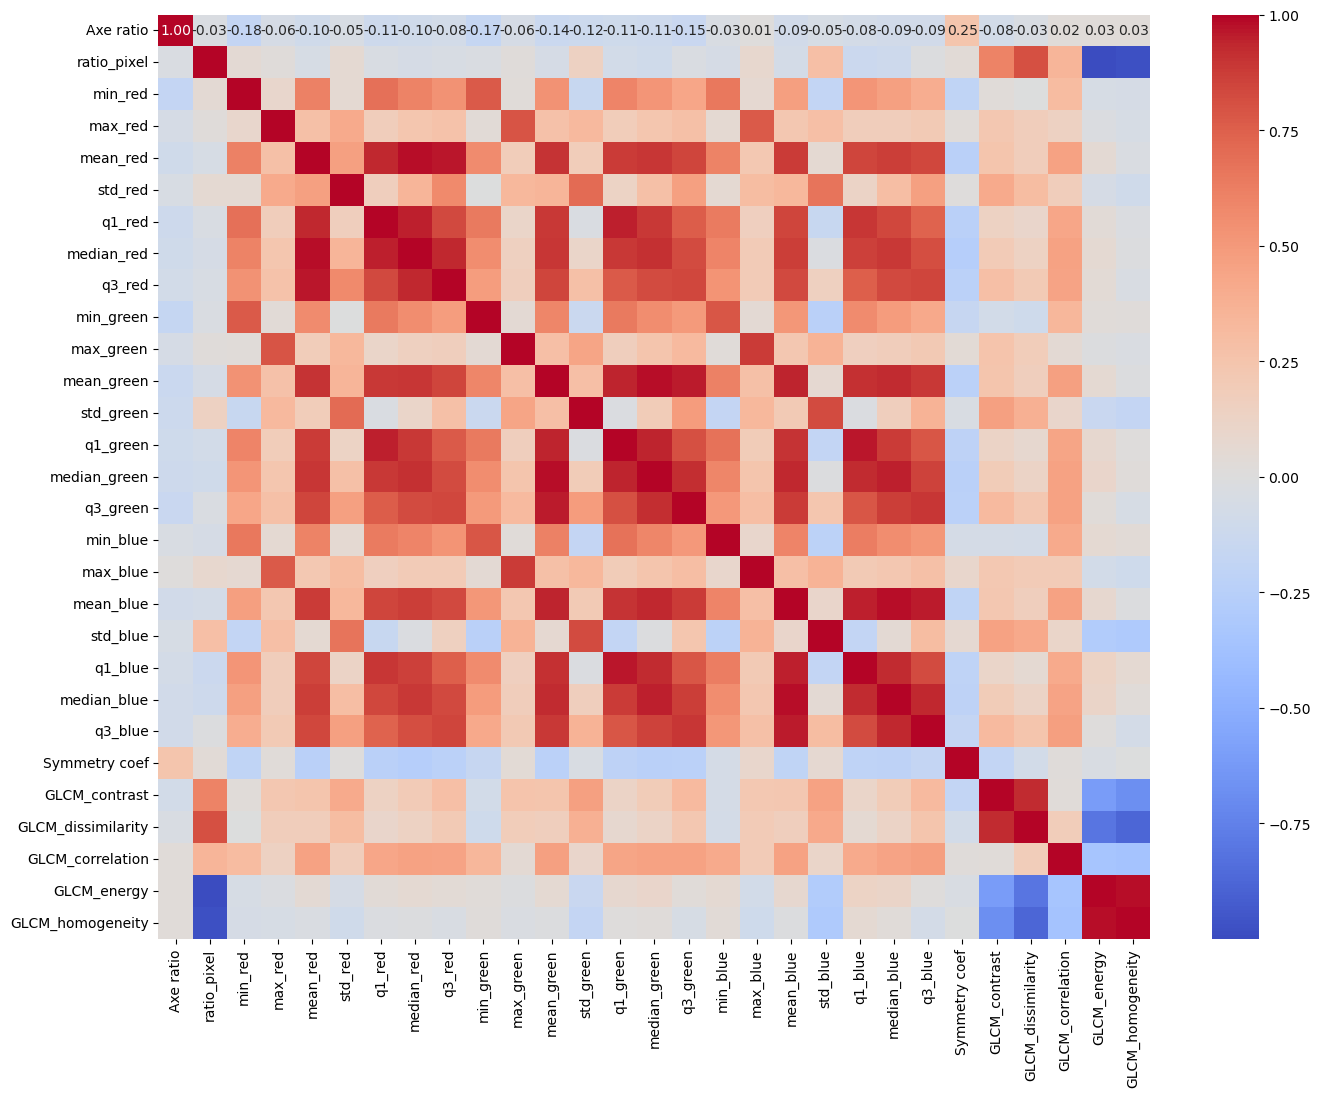

Highly correlated features: [('ratio_pixel', 'GLCM_energy'), ('ratio_pixel', 'GLCM_homogeneity'), ('mean_red', 'q1_red'), ('mean_red', 'median_red'), ('mean_red', 'q3_red'), ('mean_red', 'mean_green'), ('q1_red', 'median_red'), ('q1_red', 'q1_green'), ('median_red', 'q3_red'), ('median_red', 'median_green'), ('mean_green', 'q1_green'), ('mean_green', 'median_green'), ('mean_green', 'q3_green'), ('mean_green', 'mean_blue'), ('mean_green', 'q1_blue'), ('mean_green', 'median_blue'), ('q1_green', 'median_green'), ('q1_green', 'mean_blue'), ('q1_green', 'q1_blue'), ('median_green', 'q3_green'), ('median_green', 'mean_blue'), ('median_green', 'q1_blue'), ('median_green', 'median_blue'), ('mean_blue', 'q1_blue'), ('mean_blue', 'median_blue'), ('mean_blue', 'q3_blue'), ('q1_blue', 'median_blue'), ('median_blue', 'q3_blue'), ('GLCM_contrast', 'GLCM_dissimilarity'), ('GLCM_energy', 'GLCM_homogeneity')]


In [38]:
# Compute correlation matrix
corr_matrix = X.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Identify features with correlation higher than 0.9
high_corr_var = np.where(abs(corr_matrix) > 0.9)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]
print("Highly correlated features:", high_corr_var)

In [39]:
# List of features to drop
features_to_drop = [
    'GLCM_energy', 'GLCM_homogeneity', 'q1_red', 'median_red', 'q3_red', 'mean_green', 
    'q1_green', 'q3_green', 'mean_blue', 'q1_blue', 'GLCM_dissimilarity'
]

# Drop the features
X_reduced = X.drop(features_to_drop, axis=1)
print("Remaining features after dropping highly correlated ones:", X_reduced.columns)


Remaining features after dropping highly correlated ones: Index(['Axe ratio', 'ratio_pixel', 'min_red', 'max_red', 'mean_red', 'std_red',
       'min_green', 'max_green', 'std_green', 'median_green', 'min_blue',
       'max_blue', 'std_blue', 'median_blue', 'q3_blue', 'Symmetry coef',
       'GLCM_contrast', 'GLCM_correlation'],
      dtype='object')


In [40]:
# Division des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y,test_size=0.2, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_reduced, y_2,test_size=0.2, random_state=0)

In [42]:
# Initialize the model
model = RandomForestClassifier(random_state=0)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Score:", cv_scores.std())

# Hyperparameter Optimization with GridSearchCV
param_grid = {
    'n_estimators': [70, 90, 100, 110, 120, 125, 130],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 2, 5, 7, 9, 11],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=skf, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

Cross-validation Scores: [0.75  0.75  0.75  0.7   0.825]
Mean CV Score: 0.7550000000000001
Standard Deviation of CV Score: 0.039999999999999994
Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
Best Parameters: {'bootstrap': False, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 120}
Best Cross-validation Score: 0.78


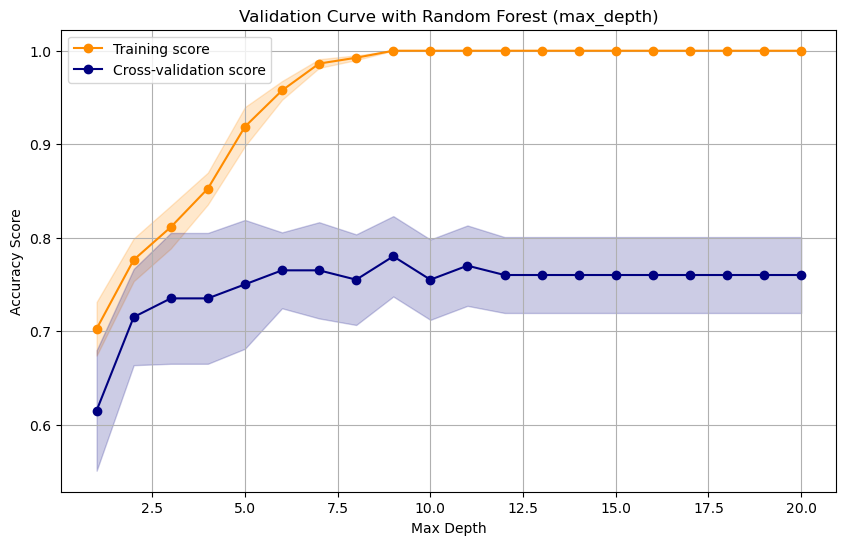

In [43]:
# Define the range for the hyperparameter 'max_depth'
param_range = np.arange(1, 21)

# Initialisation du modèle de régression logistique multinomiale
best_rf = grid_search.best_estimator_

# Perform validation curve
train_scores, test_scores = validation_curve(
    estimator=best_rf,
    X=X_train,
    y=y_train,
    param_name='max_depth',
    param_range=param_range,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the validation curve for max_depth
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with Random Forest (max_depth)")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy")
plt.legend(loc="best")
plt.grid()
plt.show()


In [44]:
# Prédiction sur l'ensemble de test avec les meilleurs paramètres
y_pred_test = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)

# Évaluation du modèle sur les donnée de test
print("Classification Report for on test:")
print(classification_report(y_test, y_pred_test))

# Évaluation du modèle sur les donnée train
print("Classification Report for on train:")
print(classification_report(y_train, y_pred_train))

Classification Report for on test:
              precision    recall  f1-score   support

         Bee       0.65      0.95      0.77        21
   Bumblebee       0.89      0.64      0.74        25
   Butterfly       1.00      0.50      0.67         2
   Hover fly       0.00      0.00      0.00         1
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.74        50
   macro avg       0.51      0.42      0.44        50
weighted avg       0.76      0.74      0.72        50

Classification Report for on train:
                 precision    recall  f1-score   support

            Bee       0.99      1.00      0.99        94
Bee & Bumblebee       1.00      1.00      1.00         1
      Bumblebee       1.00      1.00      1.00        75
      Butterfly       1.00      1.00      1.00        13
      Dragonfly       1.00      1.00      1.00         1
      Hover fly       1.00      0.88      0.93         8
           Wasp       1.00      1.00    

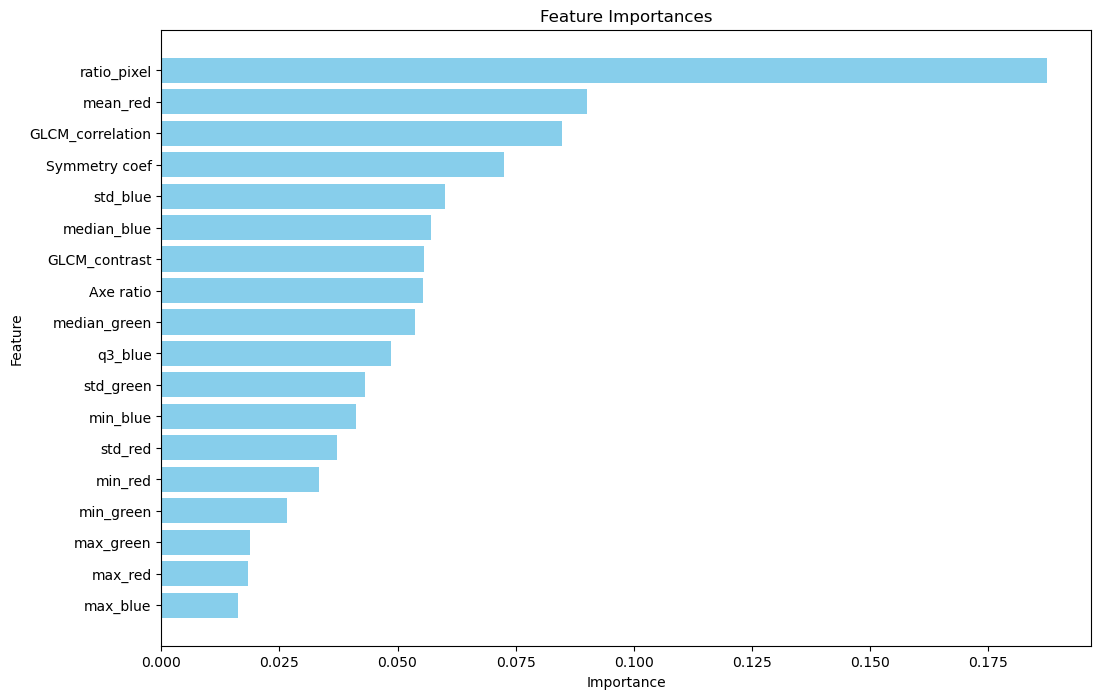

In [160]:
# Extract feature importances from the best model
feature_importances = pd.DataFrame({'feature': X_train_2.columns, 'importance': best_rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Sort for better visualization
sorted_idx = feature_importances['importance'].sort_values(ascending=False).index
sorted_features = feature_importances.loc[sorted_idx]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_features['feature'], sorted_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()


In [45]:
# Evaluate the final model on training data
y_pred_train = best_rf.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_pred_train))

# Evaluate the final model on test data
y_pred_test = best_rf.predict(X_test)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test))

# Evaluate model performance with cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(best_rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print("Repeated Cross-validation Scores:", n_scores)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
print('Median Accuracy:', np.median(n_scores))


Classification Report on Training Data:
                 precision    recall  f1-score   support

            Bee       0.99      1.00      0.99        94
Bee & Bumblebee       1.00      1.00      1.00         1
      Bumblebee       1.00      1.00      1.00        75
      Butterfly       1.00      1.00      1.00        13
      Dragonfly       1.00      1.00      1.00         1
      Hover fly       1.00      0.88      0.93         8
           Wasp       1.00      1.00      1.00         8

       accuracy                           0.99       200
      macro avg       1.00      0.98      0.99       200
   weighted avg       1.00      0.99      0.99       200

Classification Report on Test Data:
              precision    recall  f1-score   support

         Bee       0.65      0.95      0.77        21
   Bumblebee       0.89      0.64      0.74        25
   Butterfly       1.00      0.50      0.67         2
   Hover fly       0.00      0.00      0.00         1
        Wasp       0.00

## Deep Learning Neural network : MLP

In [69]:
# Définir le modèle MLP
mlp = MLPClassifier()

# Définir la grille des hyperparamètres
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu','logistic','identity'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Exécuter la recherche
grid_search.fit(X_train_2, y_train_2)

# Afficher les meilleurs paramètres et la meilleure performance
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure performance:", grid_search.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Meilleurs paramètres: {'activation': 'identity', 'alpha': 0.001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
Meilleure performance: 0.6926923076923076


In [70]:
mlp = MLPClassifier(activation='tanh', solver='lbfgs',learning_rate='constant',hidden_layer_sizes=(100,),alpha=0.0001,random_state=0)
mlp.fit(X_train_2,y_train_2)
# Évaluer le meilleur modèle
y_pred_test = mlp.predict(X_test_2)
y_pred_train = mlp.predict(X_train_2)


print("Classification Report on test:")
print(classification_report(y_test_2, y_pred_test))

print("Classification Report on train:")
print(classification_report(y_train_2, y_pred_train))

Classification Report on test:
              precision    recall  f1-score   support

       Autre       0.50      0.14      0.22         7
         Bee       0.67      0.70      0.68        20
   Bumblebee       0.70      0.83      0.76        23

    accuracy                           0.68        50
   macro avg       0.62      0.56      0.56        50
weighted avg       0.66      0.68      0.65        50

Classification Report on train:
              precision    recall  f1-score   support

       Autre       0.76      0.48      0.59        27
         Bee       0.76      0.82      0.79        95
   Bumblebee       0.73      0.75      0.74        77

    accuracy                           0.75       199
   macro avg       0.75      0.69      0.71       199
weighted avg       0.75      0.75      0.74       199



In [71]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# Cross-validation avec le meilleur modèle
cross_val_scores = cross_val_score(mlp, X, y_2, cv=cv, scoring='accuracy', n_jobs=-1)

print("Scores de la cross-validation:", cross_val_scores)
print("Moyenne des scores de la cross-validation:", np.mean(cross_val_scores))
print("Écart-type des scores de la cross-validation:", np.std(cross_val_scores))
print("Median des scores de la cross-validation:", np.median(cross_val_scores))


Scores de la cross-validation: [0.64       0.64       0.76       0.72       0.84       0.68
 0.68       0.8        0.6        0.79166667 0.72       0.8
 0.76       0.72       0.76       0.88       0.64       0.8
 0.72       0.58333333 0.76       0.64       0.64       0.88
 0.72       0.72       0.68       0.68       0.6        0.70833333]
Moyenne des scores de la cross-validation: 0.7187777777777776
Écart-type des scores de la cross-validation: 0.07795408588504416
Median des scores de la cross-validation: 0.72


## Model train on auto encoded features 

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [73]:
def encodedData(X_scaled, dim):
    
    reconstruction_losses = []
    
    # Définir l'architecture de l'autoencodeur
    input_dim = X_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    # Entraîner l'autoencodeur
    autoencoder.fit(X_scaled, X_scaled,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=0)
    
    # Évaluer la perte de reconstruction
    reconstructed_X = autoencoder.predict(X_scaled)
    reconstruction_loss = mean_squared_error(X_scaled, reconstructed_X)
    reconstruction_losses.append(reconstruction_loss)
    
    # Extraire les encodages
    encoder = Model(input_layer, encoded)
    encoded_data = encoder.predict(X_scaled)
    
    reconstructed_X = autoencoder.predict(X_scaled)
    reconstruction_loss = mean_squared_error(X_scaled, reconstructed_X)
    
    return encoded_data, reconstruction_loss

In [74]:
X_encoded, loss = encodedData(X,7)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y,test_size=0.2)

best_svm.fit(X_train,y_train)

y_pred_test = best_svm.predict(X_test)
y_pred_train = best_svm.predict(X_train)

# Évaluation du modèle sur les donnée de test
print("Classification Report for on test:")
print(classification_report(y_test, y_pred_test))

# Évaluation du modèle sur les donnée train
print("Classification Report for on train:")
print(classification_report(y_train, y_pred_train))

Classification Report for on test:
              precision    recall  f1-score   support

         Bee       0.49      0.77      0.60        22
   Bumblebee       0.60      0.39      0.47        23
   Butterfly       0.00      0.00      0.00         3
   Hover fly       0.00      0.00      0.00         1
        Wasp       0.00      0.00      0.00         1

    accuracy                           0.52        50
   macro avg       0.22      0.23      0.21        50
weighted avg       0.49      0.52      0.48        50

Classification Report for on train:
              precision    recall  f1-score   support

         Bee       0.56      0.86      0.68        93
   Bumblebee       0.64      0.42      0.50        77
   Butterfly       0.80      0.33      0.47        12
   Dragonfly       0.00      0.00      0.00         1
   Hover fly       0.00      0.00      0.00         8
        Wasp       0.00      0.00      0.00         8

    accuracy                           0.58       199
   mac

# Test our model with our real test set

# Extract feature

In [46]:
bug_test_id = [i+1 for i in range(250,347)]
test_im_dir_path = r"./Data/test_set/test/test/pictures/"
test_mask_dir_path = r"./Data/test_set/test/test/masks/"

test_pictures_path = [test_im_dir_path + "{0}.JPG".format(i) for i in bug_test_id]
test_masks_path = [test_mask_dir_path + "binary_{0}.tif".format(i) for i in bug_test_id]

In [77]:
#index_sym_test =  []
#for i in test_masks_path:
#    index_sym_test.append(calculate_symmetry_index_within_insect_region(np.array(cv2.imread(i, cv2.IMREAD_GRAYSCALE))))
#    print(i)


In [78]:
#index_sym_test = [i/100 for i in index_sym_test]

In [79]:
"""
test_sym_ratio = []
for path in test_masks_path:

    longest_line = find_longest_line(np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE)))
    longest_perpendicular_line = find_longest_perpendicular_line(np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE)), longest_line)

    ratio, _, _ = calculate_ratio(longest_perpendicular_line, longest_line)
    test_sym_ratio.append(ratio)
"""

'\ntest_sym_ratio = []\nfor path in test_masks_path:\n\n    longest_line = find_longest_line(np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE)))\n    longest_perpendicular_line = find_longest_perpendicular_line(np.array(cv2.imread(path, cv2.IMREAD_GRAYSCALE)), longest_line)\n\n    ratio, _, _ = calculate_ratio(longest_perpendicular_line, longest_line)\n    test_sym_ratio.append(ratio)\n'

In [80]:
"""
bug_ratio = []
for m in test_masks_path:
    ratio = calculate_bug_to_image_pixels_ratio(np.array(cv2.imread(m, cv2.IMREAD_GRAYSCALE)))
    bug_ratio.append(ratio)
"""

'\nbug_ratio = []\nfor m in test_masks_path:\n    ratio = calculate_bug_to_image_pixels_ratio(np.array(cv2.imread(m, cv2.IMREAD_GRAYSCALE)))\n    bug_ratio.append(ratio)\n'

In [81]:
#bug_data_with_feature_test =  pd.DataFrame()
#bug_data_with_feature_test['ID']=bug_test_id
#bug_data_with_feature_test['Symmetry Index']=index_sym_test
#bug_data_with_feature_test['Axe ratio'] = test_sym_ratio
#bug_data_with_feature_test['ratio_pixel'] = bug_ratio

In [82]:
"""
# Liste pour stocker les caractéristiques calculées pour chaque insecte
caracteristiques = []

id = 251
# Parcourir les images et masques dans les tableaux picture_arr et mask_arr
for i in range(len(test_masks_path)):
    # Charger l'image de base et le masque correspondant
    img = np.array(Image.open(test_pictures_path[i]))
    mask = np.array(cv2.imread(test_masks_path[i], cv2.IMREAD_GRAYSCALE))

    # Calculer les caractéristiques à l'intérieur du masque pour chaque canal de couleur
    color_features = calculate_color_features_within_mask(img, mask)

    # Stocker les caractéristiques dans la liste principale
    caracteristiques.append({
        'image': id,  # Utiliser i + 1 car l'index commence à 0 mais les images sont numérotées à partir de 1
        'canal red': color_features[0],
        'canal green': color_features[1],
        'canal blue': color_features[2],
    })
    id+=1

# Création du DataFrame à partir de la liste caracteristiques
data = []
for insecte in caracteristiques:
    row_data = {'ID': insecte['image']}
    for couleur in ['red', 'green', 'blue']:
        canal = insecte['canal ' + couleur]
        row_data['min_' + couleur] = canal['min_intensity']
        row_data['max_' + couleur] = canal['max_intensity']
        row_data['mean_' + couleur] = canal['mean_intensity']
        row_data['std_' + couleur] = canal['std_deviation_intensity']
        row_data['q1_' + couleur] = canal['quartiles_intensity'][0]
        row_data['median_' + couleur] = canal['quartiles_intensity'][1]
        row_data['q3_' + couleur] = canal['quartiles_intensity'][2]
    data.append(row_data)

df = pd.DataFrame(data)
"""

"\n# Liste pour stocker les caractéristiques calculées pour chaque insecte\ncaracteristiques = []\n\nid = 251\n# Parcourir les images et masques dans les tableaux picture_arr et mask_arr\nfor i in range(len(test_masks_path)):\n    # Charger l'image de base et le masque correspondant\n    img = np.array(Image.open(test_pictures_path[i]))\n    mask = np.array(cv2.imread(test_masks_path[i], cv2.IMREAD_GRAYSCALE))\n\n    # Calculer les caractéristiques à l'intérieur du masque pour chaque canal de couleur\n    color_features = calculate_color_features_within_mask(img, mask)\n\n    # Stocker les caractéristiques dans la liste principale\n    caracteristiques.append({\n        'image': id,  # Utiliser i + 1 car l'index commence à 0 mais les images sont numérotées à partir de 1\n        'canal red': color_features[0],\n        'canal green': color_features[1],\n        'canal blue': color_features[2],\n    })\n    id+=1\n\n# Création du DataFrame à partir de la liste caracteristiques\ndata = [

In [83]:
#bug_data_with_feature_test = bug_data_with_feature_test.merge(df,how="inner",on="ID")

In [88]:
# Initialize lists to store new features
contrast_list = []
dissimilarity_list = []
correlation_list = []
energy_list = []
homogeneity_list = []

# Iterate over the image and mask paths
for img_path, mask_path in zip(test_pictures_path, test_masks_path):
    # Load the image
    image = np.array(Image.open(img_path))
    
    # Load the mask
    mask = np.array(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE))
    
    # Apply the mask to isolate the bug
    isolated_bug = image * (mask > 0)[..., np.newaxis]
    
    # Convert the isolated bug image to grayscale
    gray_bug = cv2.cvtColor(isolated_bug, cv2.COLOR_BGR2GRAY)
    
    # Calculate the GLCM and texture features
    co_matrix = skimage.feature.graycomatrix(gray_bug, [5], [0], levels=256, symmetric=True, normed=True)
    contrast = skimage.feature.graycoprops(co_matrix, 'contrast')[0][0]
    dissimilarity = skimage.feature.graycoprops(co_matrix, 'dissimilarity')[0][0]
    correlation = skimage.feature.graycoprops(co_matrix, 'correlation')[0][0]
    energy = skimage.feature.graycoprops(co_matrix, 'energy')[0][0]
    homogeneity = skimage.feature.graycoprops(co_matrix, 'homogeneity')[0][0]
    
    # Append features to lists
    contrast_list.append(contrast)
    dissimilarity_list.append(dissimilarity)
    correlation_list.append(correlation)
    energy_list.append(energy)
    homogeneity_list.append(homogeneity)

# Add new features to the DataFrame
bug_data_with_feature_test['GLCM_contrast'] = contrast_list
bug_data_with_feature_test['GLCM_dissimilarity'] = dissimilarity_list
bug_data_with_feature_test['GLCM_correlation'] = correlation_list
bug_data_with_feature_test['GLCM_energy'] = energy_list
bug_data_with_feature_test['GLCM_homogeneity'] = homogeneity_list

In [47]:
bug_data_with_feature_test = pd.read_csv("Data/test_classif_with_feature_extraction.csv", sep=";")

In [90]:
bug_data_with_feature_test = bug_data_with_feature_test.rename(columns={"Symmetry Index":"Symmetry coef"})
bug_data_with_feature_test

,ID,Symmetry coef,Axe ratio,ratio_pixel,min_red,max_red,mean_red,std_red,q1_red,median_red,...,mean_blue,std_blue,q1_blue,median_blue,q3_blue,GLCM_contrast,GLCM_dissimilarity,GLCM_correlation,GLCM_energy,GLCM_homogeneity
0,251,0.430426,0.762618,0.012571,0.000000,1.000000,0.283676,0.167732,0.164706,0.239216,...,0.439951,0.184984,0.317647,0.423529,0.552941,12.578876,0.234479,0.953110,0.987144,0.988574
1,252,0.619026,0.558535,0.015660,0.035294,1.000000,0.518236,0.189053,0.376471,0.517647,...,0.580160,0.183388,0.443137,0.588235,0.733333,11.095092,0.224919,0.981287,0.984075,0.985757
2,253,0.630505,0.666517,0.013929,0.000000,1.000000,0.251299,0.147766,0.133333,0.239216,...,0.454378,0.185078,0.321569,0.478431,0.576471,7.293443,0.187663,0.968478,0.985798,0.987638
3,254,0.578749,0.633873,0.013067,0.062745,1.000000,0.475346,0.164360,0.368627,0.462745,...,0.671385,0.216704,0.494118,0.690196,0.862745,13.380438,0.185427,0.973505,0.986625,0.988592
4,255,0.832691,0.648191,0.014473,0.000000,1.000000,0.381712,0.183285,0.243137,0.380392,...,0.499810,0.186559,0.368627,0.501961,0.639216,17.056972,0.330180,0.951110,0.985276,0.986295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,343,0.672276,0.481147,0.014897,0.015686,0.788235,0.226879,0.118245,0.145098,0.207843,...,0.406650,0.153944,0.301961,0.427451,0.521569,8.427443,0.154690,0.956475,0.984834,0.987482
93,344,0.598054,0.782487,0.017551,0.000000,0.882353,0.235471,0.149835,0.121569,0.203922,...,0.410441,0.165527,0.286275,0.427451,0.529412,10.892125,0.215368,0.958903,0.982155,0.984697
94,345,0.579212,0.742270,0.016040,0.000000,0.560784,0.190907,0.115955,0.090196,0.200000,...,0.372953,0.146124,0.278431,0.384314,0.466667,5.449522,0.107506,0.971035,0.983699,0.987938
95,346,0.596062,0.820757,0.011911,0.000000,0.945098,0.200399,0.135883,0.086275,0.188235,...,0.304941,0.174605,0.160784,0.301961,0.427451,7.737770,0.163472,0.937663,0.987863,0.989574


# Prediction

In [48]:
X_train = X[feature_selected]
X_test = bug_data_with_feature_test[feature_selected]
y_train = y_2

In [98]:
best_log_reg.fit(X_train,y_train)

log_model_pred = best_log_reg.predict(X_test)

bug_data_with_feature_test['Log label'] = log_model_pred
bug_data_with_feature_test['Log label']


0           Bee
1           Bee
2           Bee
3           Bee
4           Bee
        ...    
92          Bee
93          Bee
94          Bee
95          Bee
96    Bumblebee
Name: Log label, Length: 97, dtype: object

In [99]:
best_svm.fit(X_train,y_train)

svm_model_pred = best_log_reg.predict(X_test)

bug_data_with_feature_test['SVM label'] = svm_model_pred

In [100]:
mlp.fit(X_train,y_train)

mlp_model_pred = mlp.predict(X_test)

bug_data_with_feature_test['MLP label'] = mlp_model_pred

In [21]:
bug_data_with_feature_test = pd.read_csv("Data/test_classif_with_feature_extraction.csv", sep=";")
bug_data_with_feature_test = bug_data_with_feature_test.drop("RF label", axis=1)

In [49]:
bug_data_with_feature_test

,ID,Log label,SVM label,MLP label,RF label,Symmetry coef,Axe ratio,ratio_pixel,min_red,max_red,...,mean_blue,std_blue,q1_blue,median_blue,q3_blue,GLCM_contrast,GLCM_dissimilarity,GLCM_correlation,GLCM_energy,GLCM_homogeneity
0,251,Bee,Bee,Bee,Bee,0.430426,0.762618,0.012571,0.000000,1.000000,...,0.439951,0.184984,0.317647,0.423529,0.552941,12.578876,0.234479,0.953110,0.987144,0.988574
1,252,Bee,Bee,Bee,Bee,0.619026,0.558535,0.015660,0.035294,1.000000,...,0.580160,0.183388,0.443137,0.588235,0.733333,11.095092,0.224919,0.981287,0.984075,0.985757
2,253,Bee,Bee,Bee,Bee,0.630505,0.666517,0.013929,0.000000,1.000000,...,0.454378,0.185078,0.321569,0.478431,0.576471,7.293443,0.187663,0.968478,0.985798,0.987638
3,254,Bee,Bee,Bee,Autre,0.578749,0.633873,0.013067,0.062745,1.000000,...,0.671385,0.216704,0.494118,0.690196,0.862745,13.380438,0.185427,0.973505,0.986625,0.988592
4,255,Bee,Bee,Bumblebee,Bumblebee,0.832691,0.648191,0.014473,0.000000,1.000000,...,0.499810,0.186559,0.368627,0.501961,0.639216,17.056972,0.330180,0.951110,0.985276,0.986295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,343,Bee,Bee,Bee,Bee,0.672276,0.481147,0.014897,0.015686,0.788235,...,0.406650,0.153944,0.301961,0.427451,0.521569,8.427443,0.154690,0.956475,0.984834,0.987482
93,344,Bee,Bee,Bumblebee,Bee,0.598054,0.782487,0.017551,0.000000,0.882353,...,0.410441,0.165527,0.286275,0.427451,0.529412,10.892125,0.215368,0.958903,0.982155,0.984697
94,345,Bee,Bee,Bee,Bee,0.579212,0.742270,0.016040,0.000000,0.560784,...,0.372953,0.146124,0.278431,0.384314,0.466667,5.449522,0.107506,0.971035,0.983699,0.987938
95,346,Bee,Bee,Bee,Bee,0.596062,0.820757,0.011911,0.000000,0.945098,...,0.304941,0.174605,0.160784,0.301961,0.427451,7.737770,0.163472,0.937663,0.987863,0.989574


In [50]:
best_rf.fit(X_train, y_train)
new_df = bug_data_with_feature_test[['ID']]
rf_model_pred = best_rf.predict(X_test)
new_df.insert(loc=1, column='RF label', value=rf_model_pred)
new_df['RF label'] = rf_model_pred

In [52]:
new_df.to_csv(r"Data/test_classif_rf2.csv", index=False, sep=";")

In [51]:
new_df

,ID,RF label
0,251,Bee
1,252,Bee
2,253,Bee
3,254,Autre
4,255,Bumblebee
...,...,...
92,343,Bee
93,344,Bee
94,345,Bee
95,346,Bee
